In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplearning-final-project/template_code.py
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/how_to_use.py
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/efficientnet_b0.pth
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/resnet34.pth
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/densenet121.pth
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/resnet18.pth
/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/vgg16.pth
/kaggle/input/deeplearning-final-project/DeepDRiD/sample_submission.csv
/kaggle/input/deeplearning-final-project/DeepDRiD/val.csv
/kaggle/input/deeplearning-final-project/DeepDRiD/train.csv
/kaggle/input/deeplearning-final-project/DeepDRiD/test.csv
/kaggle/input/deeplearning-final-project/DeepDRiD/val/395/395_r1.jpg
/kaggle/input/deeplearning-final-project/DeepDRiD/val/395/395_l2.jpg
/kaggle/input/deeplearning-final-project/D

In [7]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.001
num_epochs = 20


class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))


class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img


transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x, self.backbone.layer4


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x




Modified training loop

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def train_model1(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='/kaggle/working/model.pth', save_metrics_path='/kaggle/working/training_metrics.csv'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    # Lists to store metrics for each epoch
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    train_kappa = []
    val_kappa_list = []

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        train_accuracies.append(accuracy)
        train_losses.append(epoch_loss)
        train_kappa.append(kappa)

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics, val_loss = evaluate_model1(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)  # Assuming same loss calculation for validation
        val_kappa_list.append(val_kappa)

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    # Save metrics to CSV file
    metrics_df = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train_Accuracy': train_accuracies,
        'Val_Accuracy': val_accuracies,
        'Train_Loss': train_losses,
        'Val_Loss': val_losses,
        'Train_Kappa': train_kappa,
        'Val_Kappa': val_kappa
    })
    metrics_df.to_csv(save_metrics_path, index=False)
    print(f'Metrics saved to {save_metrics_path}')

    return model


Modified evaluation method


In [9]:
def evaluate_model1(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    running_loss = 0.0  # To accumulate the validation loss
    total_samples = 0  # To accumulate the number of validation samples

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            if not test_only:
                labels = labels.to(device)
            

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

                # Calculate the loss for the current batch
                loss = criterion(outputs, labels.long())

                running_loss += loss.item() * labels.size(0)  # Accumulate loss, weighted by batch size
                total_samples += labels.size(0)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.cpu().numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.cpu().numpy())

            pbar.update(1)

    # Calculate the average loss for the validation set
    val_loss = running_loss / total_samples

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, val_loss  # Return metrics and validation loss


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall



In [10]:
def test_model(model, test_loader, device, test_only=True, prediction_path='/kaggle/working/test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


# All the custom models

In [15]:
class CustomVgg16(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        # Load the pre-trained VGG16 backbone
        model_path = '/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/vgg16.pth'
        self.backbone = models.vgg16(pretrained=True)

        # Load custom weights into the VGG16 backbone
        state_dict = torch.load(model_path, map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info.missing_keys)  # Output missing keys
        print('unexpected keys:', info.unexpected_keys)  # Output unexpected keys

        # Modify the classifier to remove the original fully connected layers
        self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Ensure fixed output size
        self.backbone.classifier = nn.Identity()  # Remove the original classifier

        # Add custom classification layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # Input size matches the backbone's final feature size
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass through the backbone
        x = self.backbone.features(x)  # Extract features
        x = self.backbone.avgpool(x)  # Pooling to get fixed-size output
        x = torch.flatten(x, 1)  # Flatten to feed into the FC layers

        # Pass through the custom classification head
        x = self.fc(x)
        return x

class CustomResnet18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        model_path = '/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/resnet18.pth'

        self.backbone = models.resnet18(pretrained=False)
        state_dict = torch.load(model_path, map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])
     
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

class CustomResnet34(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        #self.backbone = models.resnet18(pretrained=True)
        #state_dict = torch.load('pretrained_DR_resize/pretrained/resnet18.pth', map_location='cpu')
        model_path = '/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/resnet34.pth'

        self.backbone = models.resnet34(pretrained=False)
        state_dict = torch.load(model_path, map_location='cpu')

        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])
     
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x



class CustomDensenet121(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        # Define the backbone using DenseNet121
        model_path = '/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/densenet121.pth'
        self.backbone = models.densenet121(pretrained=False)  # Use pretrained=False as custom weights are loaded

        # Load the custom pretrained weights
        state_dict = torch.load(model_path, map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info.missing_keys)  # For PyTorch >= 1.9.0, use `.missing_keys`
        print('unexpected keys:', info.unexpected_keys)

        # Replace the original classifier
        self.backbone.classifier = nn.Identity()  # DenseNet uses `classifier` for its classification head

        # Define custom classification head
        self.fc = nn.Sequential(
            nn.Linear(1024, 256),  # Output from DenseNet121 backbone is 1024 features
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)  # Pass through DenseNet121 backbone
        x = self.fc(x)        # Pass through custom fully connected layers
        return x


class CustomEficientnet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        # Define the backbone using EfficientNet-B0
        model_path = '/kaggle/input/deeplearning-final-project/pretrained_DR_resize/pretrained/efficientnet_b0.pth'
        self.backbone = models.efficientnet_b0(pretrained=False)  # Use pretrained=False as custom weights are loaded

        # Load the custom pretrained weights
        state_dict = torch.load(model_path, map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info.missing_keys)  # For PyTorch >= 1.9.0, use `.missing_keys`
        print('unexpected keys:', info.unexpected_keys)

        # Replace the original classification layer
        self.backbone.classifier = nn.Identity()  # EfficientNet uses `classifier` instead of `fc`

        # Define custom classification head
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),  # Output from EfficientNet-B0 backbone is 1280 features
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)  # Pass through EfficientNet backbone
        x = self.fc(x)        # Pass through custom fully connected layers
        return x


Custom Transformation

In [16]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import random

class ApplyCLAHE:
    def __call__(self, img):
        img = np.array(img)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class BenGrahamTransform:
    def __init__(self, sigmaX=10):
        self.sigmaX = sigmaX

    def __call__(self, img):
        # Convert PIL image to NumPy array (OpenCV uses NumPy)
        img = np.array(img)
        
        # Apply Ben Graham Transformation
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert from RGB to BGR for OpenCV
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), self.sigmaX), -4, 128)
        
        # Convert back to PIL Image
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert back to RGB
        return img


class ApplyGaussianBlur:
    def __init__(self, ksize=(3, 3), sigmaX=8):
        self.ksize = ksize
        self.sigmaX = sigmaX

    def __call__(self, img):
        img = np.array(img)
        img = cv2.GaussianBlur(img, self.ksize, self.sigmaX)
        return Image.fromarray(img)

class ApplySharpening:
    def __call__(self, img):
        img = np.array(img)
        kernel = np.array([[0, -1, 0], 
                           [-1, 5, -1], 
                           [0, -1, 0]])
        img = cv2.filter2D(img, -1, kernel)
        return Image.fromarray(img)

class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

custom_transform_train_clahe = transforms.Compose([
    transforms.Resize((224, 224)),
    ApplyCLAHE(),  # Apply CLAHE
    ApplySharpening(),  # Apply sharpening
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform_train_ben = transforms.Compose([
    transforms.Resize((224, 224)),
    BenGrahamTransform(sigmaX=8),  # Apply Ben Graham transformation
    ApplySharpening(),  # Apply sharpening
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform_train_clahe_ben = transforms.Compose([
    transforms.Resize((224, 224)),
    ApplyCLAHE(),  # Apply CLAHE
    BenGrahamTransform(sigmaX=8),  # Apply Ben Graham transformation
    ApplySharpening(),  # Apply sharpening
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform_train_clahe_given = transforms.Compose([
    transforms.Resize((256, 256)),
    ApplyCLAHE(),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Oversampling

In [13]:
import pandas as pd
from sklearn.utils import resample

# Load the original dataset
file_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/train.csv'
train_dataset = pd.read_csv(file_path)

# Group by 'patient_id' to oversample at the patient level
patient_group = train_dataset.groupby('patient_id').agg({'patient_DR_Level': 'first'}).reset_index()
print("patient group:\n", patient_group.head())

# Calculate the maximum number of patients in any DR_Level
max_patients = patient_group['patient_DR_Level'].value_counts().max()
print("max_patients:\n", max_patients)

# Oversample each class (DR_Level) at the patient level
print(" values: \n", patient_group['patient_DR_Level'].unique())

samples = []
for level in patient_group['patient_DR_Level'].unique():
    level_patients = patient_group[patient_group['patient_DR_Level'] == level]
    oversampled_patients = resample(level_patients, 
                                    replace=True,  # Sample with replacement
                                    n_samples=max_patients,  # Sample to the max count
                                    random_state=42)
    samples.append(oversampled_patients)

# Combine all the oversampled patient data
oversampled_patients_df = pd.concat(samples)

# Merge with the original dataset to get all the rows of images for the oversampled patients
modified_train = train_dataset.merge(oversampled_patients_df[['patient_id']], on='patient_id', how='right')

# Save the new dataset to 'modified_train.csv'
modified_train_csv_path = '/kaggle/working/modified_train_csv.csv'
modified_train.to_csv(modified_train_csv_path, index=False)

print(f"Modified dataset saved to 'modified_train.csv' with {modified_train.shape[0]} rows.")

patient group:
    patient_id  patient_DR_Level
0           1                 0
1           2                 2
2           3                 1
3           4                 4
4           5                 0
max_patients:
 90
 values: 
 [0 2 1 4 3]
Modified dataset saved to 'modified_train.csv' with 1800 rows.


In [23]:
# Choose between 'single image' and 'dual images' pipeline
# This will affect the model definition, dataset pipeline, training and evaluation

mode = 'single'  # forward single image to the model each time
# mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
model = CustomEficientnet(num_classes=5, dropout_rate=0.3)

print(model, '\n')
print('Pipeline Mode:', mode)

#Dataset Directories
train_csv_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/train.csv'
val_csv_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/val.csv'
test_csv_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/test.csv'

train_img_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/train'
val_img_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/val'
test_imag_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/test'

#Modified train csv file
modified_train_csv_path = '/kaggle/working/modified_train_csv.csv'

# Create datasets
train_dataset = RetinopathyDataset(modified_train_csv_path, train_img_path, transform_train, mode)
val_dataset = RetinopathyDataset(val_csv_path, val_img_path, transform_test, mode)
test_dataset = RetinopathyDataset(test_csv_path, test_imag_path, transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


model_save_path = '/kaggle/working/model.pth'
history_save_path = '/kaggle/working/training_metrics.csv'
# Train and evaluate the model with the training and validation set
model = train_model1(model, train_loader, val_loader, device, criterion, optimizer,
                     lr_scheduler=lr_scheduler, num_epochs=num_epochs,
                     checkpoint_path= model_save_path, save_metrics_path = history_save_path)

# Load the pretrained checkpoint
state_dict = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
test_model(model, test_loader, device, test_only=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-400cb19ed439>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

missing keys: ['classifier.1.weight', 'classifier.1.bias']
unexpected keys: []
CustomEficientnet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1)

<ipython-input-23-90015ebf2d29>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_save_path, map_location='cpu')



[Val] Kappa: 0.8522 Accuracy: 0.6925 Precision: 0.6883 Recall: 0.6925
[Val] Best kappa: 0.8569, Epoch 19
Metrics saved to /kaggle/working/training_metrics.csv
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.94 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions.csv


   Epoch  Train_Accuracy  Val_Accuracy  Train_Loss  Val_Loss  Train_Kappa  \
0      1        0.603333        0.5850    0.988386  1.053363     0.776591   
1      2        0.733889        0.6900    0.704779  0.982480     0.855223   
2      3        0.778333        0.6575    0.601408  1.099811     0.887821   
3      4        0.802222        0.6400    0.561219  1.073444     0.878316   
4      5        0.845000        0.7125    0.467599  1.227980     0.917499   

   Val_Kappa  
0   0.852196  
1   0.852196  
2   0.852196  
3   0.852196  
4   0.852196  


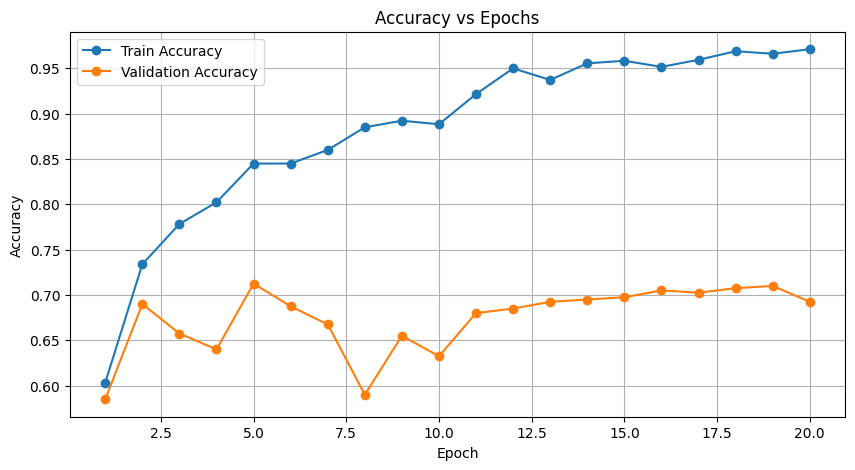

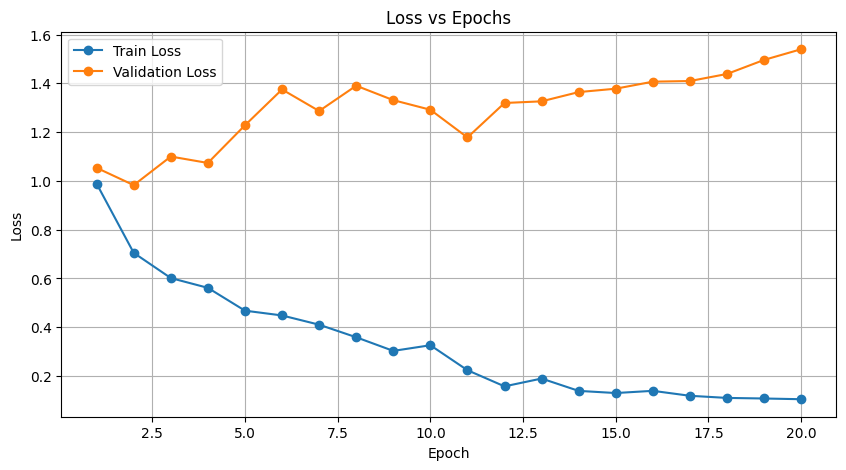

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming metrics_df is your DataFrame
history_save_path = '/kaggle/working/training_metrics.csv'
metrics_df = pd.read_csv(history_save_path)
print(metrics_df.head())

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Epoch'], metrics_df['Train_Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Epoch'], metrics_df['Val_Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')  # Save the accuracy plot
plt.show()

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Epoch'], metrics_df['Train_Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Epoch'], metrics_df['Val_Loss'], label='Validation Loss', marker='o')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')  # Save the loss plot
plt.show()


GradCAM

In [ ]:
pip install torchcam

In [ ]:
model = CustomVgg16()
model_save_path = '/kaggle/working/model.pth'
state_dict = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(state_dict, strict=True)

model.to(device)

target_layer = model.backbone.features
print(target_layer)

In [ ]:
import torch.nn as nn

# Update ReLU in your model
for module in model.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].clone()

    def save_activations(self, module, input, output):
        self.activations = output.clone()

    def generate(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        output[:, target_class].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]

        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)

        # Normalize the Grad-CAM map
        ggrad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)

        return grad_cam_map

# Load the pre-trained ResNet34 model with updated weights parameter
model = CustomVgg16()
model_save_path = '/kaggle/working/model.pth'
state_dict = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(state_dict, strict=True)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deeplearning-final-project/DeepDRiD/test/347/347_l1.jpg', '/kaggle/input/deeplearning-final-project/DeepDRiD/test/347/347_l2.jpg'] 
#/kaggle/input/deeplearning-final-project/DeepDRiD/test/347/347_l1.jpg' ['/kaggle/input/deepdrid/DeepDRiD/test/347/347_r1.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/354/354_l2.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/377/377_l1.jpg']  # Replace with your image paths
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])

# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_images = input_images.to(device)



model.to(device)

target_layer = model.backbone.features[28]
print(target_layer)


# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, target_layer)

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    try:
        grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0))
    except Exception as e:
        print(f"Error generating Grad-CAM map for image {i}: {e}")

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= superimposed_image.max()

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()
    output_path = f'/kaggle/working/gradcam_visualization_{i + 1}.png'  # Customize the filename as needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [ ]:
# Single image preprocessing
from PIL import Image
import torch

img_path = '/kaggle/input/deeplearning-final-project/DeepDRiD/train/1/1_l1.jpg'
img = Image.open(img_path).convert('RGB')

# Apply transformations
img = transform(img)

# Add batch dimension
img = img.unsqueeze(0)  # Shape: (1, C, H, W)

# Move image to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = img.to(device)

# Perform inference
model = model.to(device)
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    output = model(img)

print(output)


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        self.target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        self.target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        # Clone the gradients to avoid in-place modification during backpropagation
        self.gradients = grad_output[0].clone()

    def save_activations(self, module, input, output):
        # Clone the activations to avoid in-place modification
        self.activations = output.clone()

    def generate(self, input_image, output, target_class=None):
        # Forward pass
        output = output
    
        if target_class is None:
            target_class = output.argmax(dim=1).item()
    
        # Zero gradients before backward pass
        self.model.zero_grad()
    
        # Backward pass with respect to the target class
        try:
            output[:, target_class].backward()
        except Exception as e:
            print(f"Error during backward pass: {e}")
            return None
    
        # Check if gradients and activations were captured
        if self.gradients is None or self.activations is None:
            print("Error: Gradients or Activations are None")
            return None
    
        # Get the gradients and activations
        try:
            gradients = self.gradients.cpu().data.numpy()[0]
            activations = self.activations.cpu().data.numpy()[0]
        except Exception as e:
            print(f"Error accessing gradients/activations: {e}")
            return None
    
        # Compute the weights (average of gradients)
        weights = np.mean(gradients, axis=(1, 2))
    
        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]
    
        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)
    
        # Normalize the Grad-CAM map
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
    
        return grad_cam_map


# Load the pre-trained ResNet34 model with updated weights parameter
model = CustomVgg16()  # Replace this with your actual model
model_save_path = '/kaggle/working/model.pth'
state_dict = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(state_dict, strict=True)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deeplearning-final-project/DeepDRiD/test/347/347_l1.jpg', '/kaggle/input/deeplearning-final-project/DeepDRiD/test/347/347_l2.jpg']
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])
print("imges shape:", input_images.shape)
# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
input_images = input_images.to(device)
model.to(device)

# Define the target layer (Ensure this is the correct layer for your model)
target_layer = model.backbone.features[28]  # Modify this if necessary based on your custom model
print(target_layer)

outputs = []
for i in range(len(images)):
    output = model(input_images[i].unsqueeze(0))
    outputs.append(output)
    print("output:", output)

print('outputs:', outputs)

# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, target_layer)

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    
    print("input image shape:",input_images[i].unsqueeze(0).shape)
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0), outputs[i])

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= (superimposed_image.max() + 1e-8)  # Avoid division by zero

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()

    # Save the visualization
    output_path = f'/kaggle/working/gradcam_visualization_{i + 1}.png'  # Customize the filename as needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight')


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        self.target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        self.target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        # Clone the gradients to avoid in-place modification during backpropagation
        self.gradients = grad_output[0].clone()

    def save_activations(self, module, input, output):
        # Clone the activations to avoid in-place modification
        self.activations = output.clone()

    def generate(self, input_image, output, target_class=None):
        # Forward pass
        output = output
    
        if target_class is None:
            target_class = output.argmax(dim=1).item()
    
        # Zero gradients before backward pass (important for each image)
        self.model.zero_grad()
    
        # Backward pass with respect to the target class, using retain_graph=True
        try:
            output[:, target_class].backward(retain_graph=True)
        except Exception as e:
            print(f"Error during backward pass: {e}")
            return None
    
        # Check if gradients and activations were captured
        if self.gradients is None or self.activations is None:
            print("Error: Gradients or Activations are None")
            return None
    
        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
    
        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))
    
        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]
    
        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)
    
        # Normalize the Grad-CAM map
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
    
        return grad_cam_map

grad_cam = GradCAM(model, target_layer)

for i in range(len(images)):
    print(f"Processing image {i+1}")
    
    # Forward pass
    output = model(input_images[i].unsqueeze(0))

    # Generate Grad-CAM
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0), output)
    
    if grad_cam_map is not None:
        # Visualize and save Grad-CAM results
        grad_cam_map = cv2.resize(grad_cam_map, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        original_image = np.array(images[i].resize((224, 224))) / 255.0
        superimposed_image = heatmap + original_image
        superimposed_image /= (superimposed_image.max() + 1e-8)

        # Plot and save results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_image)
        plt.title('Grad-CAM')
        plt.axis('off')

        plt.show()

        output_path = f'gradcam_visualization_{i + 1}.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
